<a href="https://colab.research.google.com/github/harshil017/XGBoostvsRandomForest/blob/main/XGBoostvsRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Loading the dataset
from google.colab import drive
drive.mount('/content/drive')
train_dir = "drive/MyDrive/house-prices/train.csv"
test_dir = "drive/MyDrive/house-prices/test.csv"

Mounted at /content/drive


In [3]:
#Importing all the necessary libraries
import xgboost as xgb
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,accuracy_score, r2_score
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler , OneHotEncoder


In [12]:
#Data filtering, removing unnecssary columns and also columns with a lot of missing values
data_set = pd.read_csv(train_dir)
X = data_set.iloc[:,:-1]
y = data_set.iloc[:,-1]
X = X.drop(columns=['Id'])
missing_values = X.isnull().sum().sort_values().index
# Calculate the percentage of missing values in each column of the training set
missing_percentages = X.isnull().mean() * 100
# Filter columns with more than 65% missing values in the training set(I decided 65% for the threshold you can select yours and try )
columns_to_keep = missing_percentages[missing_percentages <= 65].index
# Create a new training DataFrame with selected columns
x_filtered = X[columns_to_keep]
column_means = x_filtered.mean()
x_filtered = x_filtered.fillna(column_means)

<ipython-input-12-f69e79f9bcfc>:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_means = x_filtered.mean()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-13-fba379b86e10>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y,color='g',shade=True)


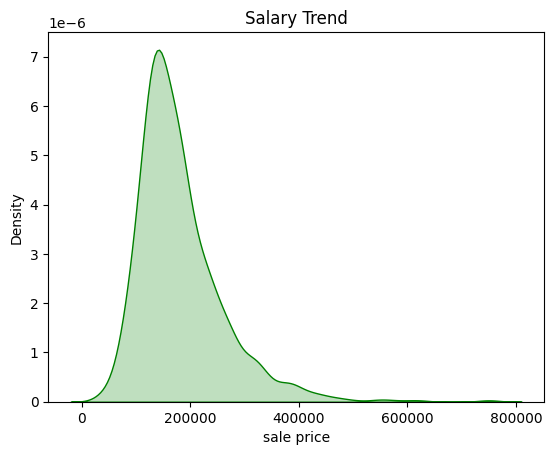

In [13]:
#Visualizing the target variable(Sales Price) and trying to understand the trend and pattern in it.
print(y.describe())
sns.kdeplot(y,color='g',shade=True)
plt.title("Salary Trend")
plt.xlabel("sale price")
plt.ylabel("Density")
plt.show()

In [14]:
#Converting the categorical and numerical columns to the correct format
num_cols = x_filtered.select_dtypes(include = ['int64', 'float64']).columns.tolist()
cat_cols = x_filtered.select_dtypes(include = ['object']).columns.tolist()
# StandardScaler for Num, and OneHotEncoder for Cat
scaler = StandardScaler()
encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
num_cols_df= pd.DataFrame(scaler.fit_transform(x_filtered[num_cols]), columns = num_cols)
cat_cols_df = pd.DataFrame(encoder.fit_transform(x_filtered[cat_cols]), columns = encoder.get_feature_names_out(cat_cols))

x_processed = pd.concat([num_cols_df, cat_cols_df], axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
#Dropping null values
x_processed[x_processed.isnull().any(axis = 1)]
x_processed.dropna(inplace = True)
x_processed[x_processed.isnull().any(axis = 1)]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [16]:
correlation_matrix = x_processed.corr()

# Finding all the columns which have a strong negative and positive negtaive correlation
#Then eliminating the common columns based on manual judgement and columns relation (Again I decided the threshold to be 75% you can select any value)
correlation_list = []
for i in correlation_matrix:
  for j in correlation_matrix:
    if (correlation_matrix[i][j] < -0.75 or correlation_matrix[i][j] > 0.75) and i != j:
      correlation_list.append((i,j))
x_processed = x_processed.drop(columns=['GarageYrBlt','GarageCars','1stFlrSF'])
    

[('YearBuilt', 'GarageYrBlt'), ('TotalBsmtSF', '1stFlrSF'), ('1stFlrSF', 'TotalBsmtSF'), ('GrLivArea', 'TotRmsAbvGrd'), ('TotRmsAbvGrd', 'GrLivArea'), ('GarageYrBlt', 'YearBuilt'), ('GarageCars', 'GarageArea'), ('GarageArea', 'GarageCars')]


<ipython-input-16-42f39837327d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = x_filtered.corr()


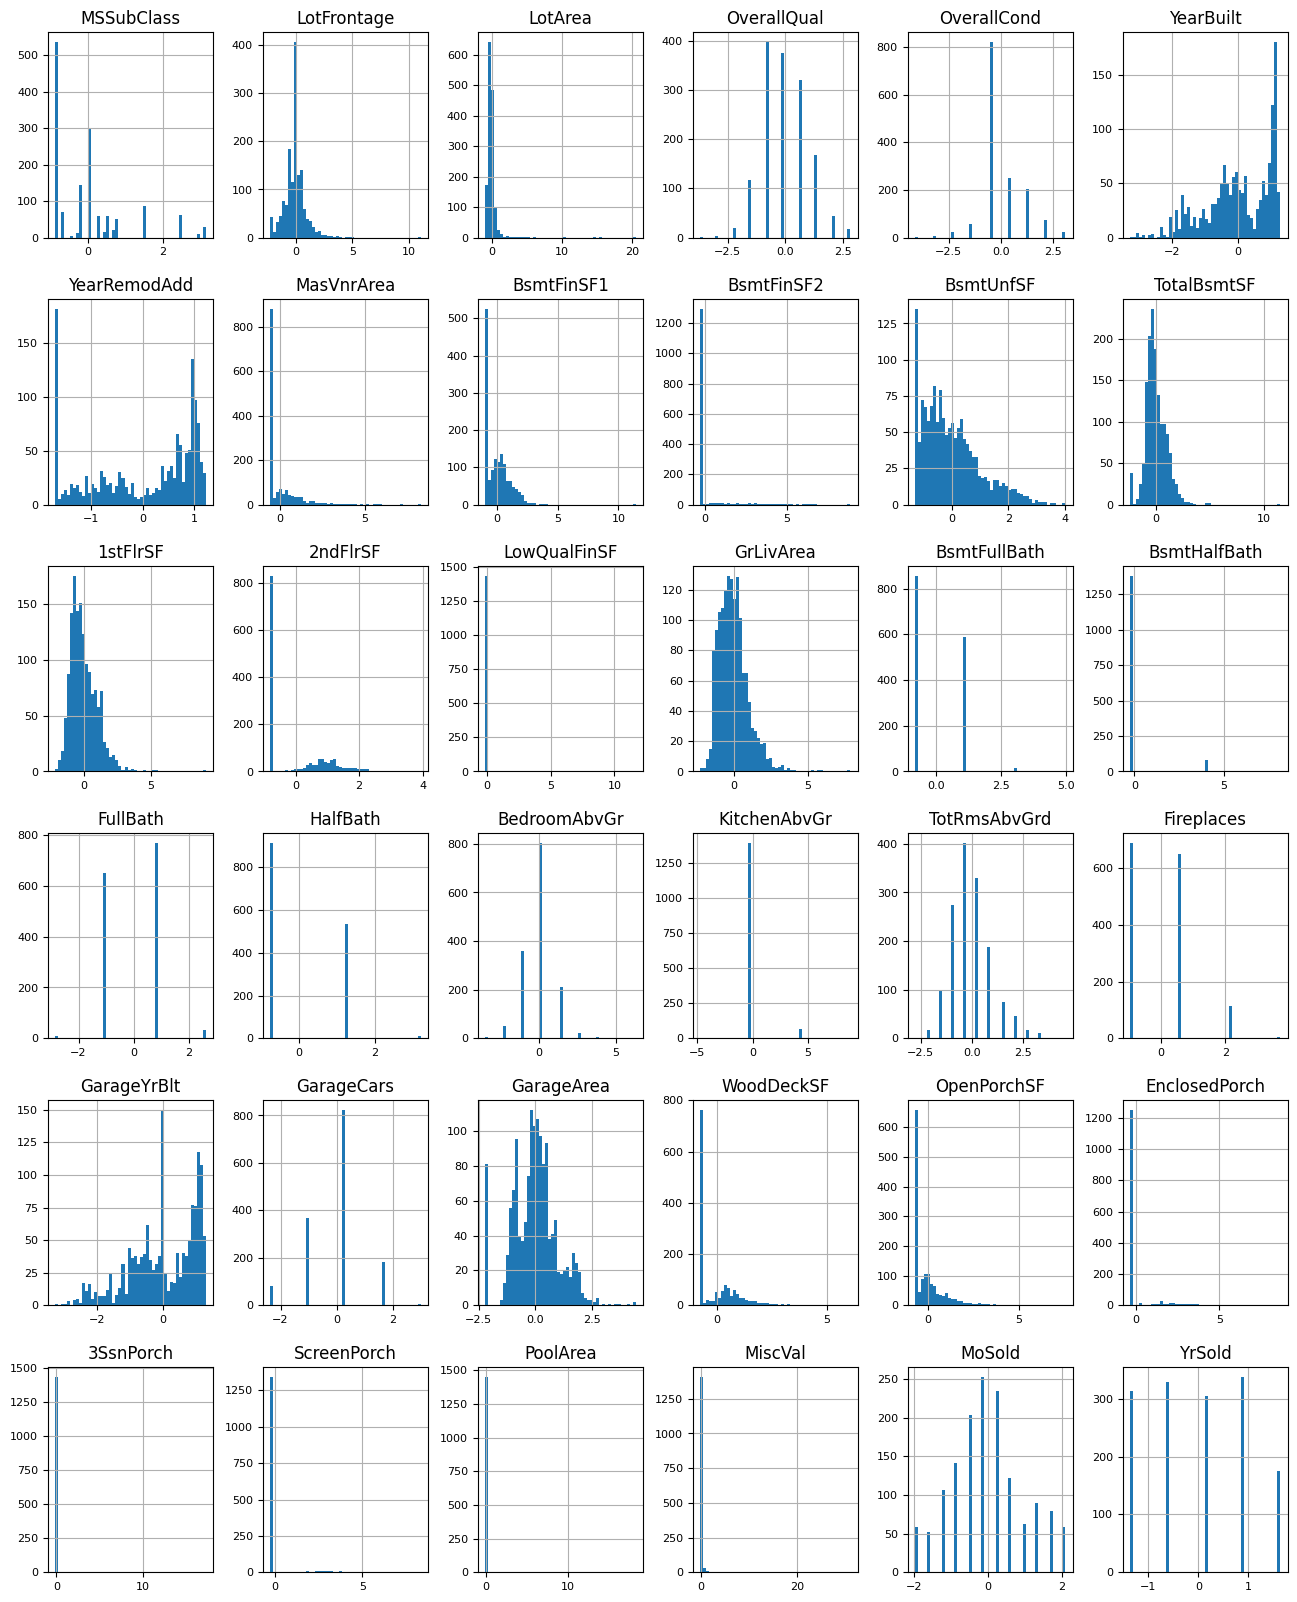

In [17]:
#Visualizing all the numeric values columns to see the distribution of data and decide whether we need any scaling or not.
num_cols_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


In [19]:
# #Finding the right combination of hyperparamters for RandomForest using grid search and kfold
x_train,x_test,y_train,y_test = train_test_split(x_processed,y,test_size=0.2,random_state=32)

rf = RandomForestRegressor(random_state=32)
param_dist = {
    'n_estimators': [100, 200, 300,500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'oob_score': [True, False],
}

kf = KFold(n_splits=5,random_state=32,shuffle=True)
grid_search = GridSearchCV(estimator=rf,param_grid=param_dist,cv=kf,scoring='r2')
grid_search.fit(x_train,y_train)
print("Best parameters:", grid_search.best_params_)
print("Best OOB score:", grid_search.best_estimator_.oob_score_)
print("Best K-fold score:", grid_search.best_score_)

Best parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': sqrt, 'oob_score': True}
Best OOB score: 0.8622261846219913
Best K-fold score: 0.8512895791403506


In [20]:
#Finally Building RandomForest Regressor model based on the best paramters found
x_train,x_test,y_train,y_test = train_test_split(x_processed,y,test_size=0.2,random_state=32) 
rfe = RandomForestRegressor(max_depth= 10, max_features = 'sqrt', min_samples_leaf= 1, min_samples_split = 2, n_estimators = 500, oob_score= True)
rfe.fit(x_train, y_train)
y_pred = rfe.predict(x_test)
y_pred_train = rfe.predict(x_train)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# mae1 = mean_absolute_error(y_train, y_pred)
print(mae)
print(r2)

19957.313894311108
0.8178085671146258


In [ ]:
#Finding the right combination of hyperparamters for XGBoost using grid search and kfold
x_train,x_test,y_train,y_test = train_test_split(x_processed,y,test_size=0.2,random_state=32)
kf = KFold(n_splits=5,random_state=32,shuffle=True)
param_search = {'learning_rate': [0.1,0.01,0.001,0.0001],
              'max_depth': [3,4,5],
              'n_estimators': [500,1000,2000,3000]}
# Create the GridSearchCV object
xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_search, cv=kf, scoring='r2')

# Fit the GridSearchCV to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best R^2 score:", grid_search.best_score_)              


In [21]:
#Finally Building XGBoost model based on the best paramters found 
xgb_final = xgb.XGBRegressor(learning_rate = 0.01,max_depth = 4,n_estimators = 1000)
xgb_final.fit(x_train,y_train)
y_predict = xgb_final.predict(x_test)
r2_scored = r2_score(y_test,y_predict)
mean_error = mean_absolute_error(y_test,y_predict)
print(r2_scored)
print(mean_error)

0.8109173119014448
17913.915761451197
